In [100]:
import pandas as pd
import numpy as np
import os
from pathlib import Path 
import missingno as msno
from tabulate import tabulate
from statistics import median, mean, quantiles
import pprint
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from datetime import datetime
import csv
from geopy.geocoders import Nominatim
import folium
from IPython.display import display

In [135]:
path = Path(os.getcwd()) 
p_parent = path.parent
p_customer = str(p_parent) + '\data\olist_customers_dataset.csv'
p_geo = str(p_parent) + '\data\olist_geolocation_dataset.csv'
p_order_item = str(p_parent) + '\data\olist_order_items_dataset.csv'
p_order_payment = str(p_parent) + '\data\olist_order_payments_dataset.csv'
p_order_review = str(p_parent) + '\data\olist_order_reviews_dataset.csv'
p_orders = str(p_parent) + '\data\olist_orders_dataset.csv'
p_products = str(p_parent) + '\data\olist_products_dataset.csv'
p_sellers = str(p_parent) + '\data\olist_sellers_dataset.csv'
p_category = str(p_parent) + '\data\product_category_name_translation.csv'

customer = pd.read_csv(p_customer)
geo = pd.read_csv(p_geo)
order_item = pd.read_csv(p_order_item)
order_payment = pd.read_csv(p_order_payment)
order_review = pd.read_csv(p_order_review)
orders = pd.read_csv(p_orders)
products = pd.read_csv(p_products)
sellers = pd.read_csv(p_sellers)
category = pd.read_csv(p_category)

In [63]:
# Création d'un DF pour afficher les stats des données
def tstats (data) :
    output = []
    for col in data.columns:
    
        nonNull  = len(data) - np.sum(pd.isna(data[col]))
        nonNullprop = (nonNull / len(data[col]))*100
        unique = data[col].nunique()
        colType = str(data[col].dtype)
        output.append([col, colType, nonNull, round(nonNullprop, 1) , unique])
            
    
    df_stats = pd.DataFrame(output)
    df_stats.columns = ['nom colonne','dtype', 'valeur non null',"% de non null", 'nb_unique']

    print(tabulate(df_stats, headers='keys', tablefmt='psql'))
    
    
def filter_brazil_data(longitudes, latitudes):
    filtered_longitudes = []
    filtered_latitudes = []
    for lon, lat in zip(longitudes, latitudes):
        if -74.5 <= lon <= -34.5 and -33.75 <= lat <= 5.5:
            filtered_longitudes.append(lon)
            filtered_latitudes.append(lat)
    return filtered_longitudes, filtered_latitudes


In [20]:
order_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [33]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [44]:
order_payment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [45]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [46]:
order_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [47]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [48]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [49]:
order_customer = orders.merge(customer, on="customer_id", how ='right')
order_customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   customer_id                    99441 non-null  object
 1   customer_unique_id             99441 non-null  object
 2   customer_zip_code_prefix       99441 non-null  int64 
 3   customer_city                  99441 non-null  object
 4   customer_state                 99441 non-null  object
 5   order_id                       99441 non-null  object
 6   order_status                   99441 non-null  object
 7   order_purchase_timestamp       99441 non-null  object
 8   order_approved_at              99281 non-null  object
 9   order_delivered_carrier_date   97658 non-null  object
 10  order_delivered_customer_date  96476 non-null  object
 11  order_estimated_delivery_date  99441 non-null  object
dtypes: int64(1), object(11)
memory usage: 9.9+ MB


In [52]:
orderItems_products = order_item.merge(products, on ='product_id', how ='left').merge(sellers, on='seller_id', how = "left")
orderItems_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   order_id                    112650 non-null  object 
 1   order_item_id               112650 non-null  int64  
 2   product_id                  112650 non-null  object 
 3   seller_id                   112650 non-null  object 
 4   shipping_limit_date         112650 non-null  object 
 5   price                       112650 non-null  float64
 6   freight_value               112650 non-null  float64
 7   product_category_name       111047 non-null  object 
 8   product_name_lenght         111047 non-null  float64
 9   product_description_lenght  111047 non-null  float64
 10  product_photos_qty          111047 non-null  float64
 11  product_weight_g            112632 non-null  float64
 12  product_length_cm           112632 non-null  float64
 13  product_height

In [4]:
order_review = orders.merge(order_review, on ='order_id', how ='left')
order_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99992 entries, 0 to 99991
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       99992 non-null  object 
 1   customer_id                    99992 non-null  object 
 2   order_status                   99992 non-null  object 
 3   order_purchase_timestamp       99992 non-null  object 
 4   order_approved_at              99831 non-null  object 
 5   order_delivered_carrier_date   98199 non-null  object 
 6   order_delivered_customer_date  97005 non-null  object 
 7   order_estimated_delivery_date  99992 non-null  object 
 8   review_id                      99224 non-null  object 
 9   review_score                   99224 non-null  float64
 10  review_comment_title           11568 non-null  object 
 11  review_comment_message         40977 non-null  object 
 12  review_creation_date           99224 non-null 

In [18]:
#version courte des merges de dbs
df = orders.merge(customer, on="customer_id", how ='left')\
.merge(order_item, on= "order_id", how = 'left')\
.merge(order_payment, on ='order_id', how ='left')\
.merge(order_review, on ="order_id", how="left")\
.merge(sellers, on ='seller_id', how ="left")\
.merge(products, on = "product_id", how = 'left')\
.merge(category, on="product_category_name", how="left")

tstats(df)

+----+---------------------------------+---------+-------------------+-----------------+-------------+
|    | nom colonne                     | dtype   |   valeur non null |   % de non null |   nb_unique |
|----+---------------------------------+---------+-------------------+-----------------+-------------|
|  0 | order_id                        | object  |            119143 |           100   |       99441 |
|  1 | customer_id_x                   | object  |            119143 |           100   |       99441 |
|  2 | order_status_x                  | object  |            119143 |           100   |           8 |
|  3 | order_purchase_timestamp_x      | object  |            119143 |           100   |       98875 |
|  4 | order_approved_at_x             | object  |            118966 |            99.9 |       90733 |
|  5 | order_delivered_carrier_date_x  | object  |            117057 |            98.2 |       81018 |
|  6 | order_delivered_customer_date_x | object  |            115722 |   

In [24]:
#version courte des merges de dbs
df = orders.merge(customer, on="customer_id", how ='outer')\
.merge(order_item, on= "order_id", how = 'outer')\
.merge(order_payment, on ='order_id', how ='outer')\
.merge(order_review, on ="order_id", how="outer")\
.merge(sellers, on ='seller_id', how ="outer")\
.merge(products, on = "product_id", how = 'outer')\
.merge(category, on="product_category_name", how="outer")

tstats(df)

+----+---------------------------------+---------+-------------------+-----------------+-------------+
|    | nom colonne                     | dtype   |   valeur non null |   % de non null |   nb_unique |
|----+---------------------------------+---------+-------------------+-----------------+-------------|
|  0 | order_id                        | object  |            119143 |           100   |       99441 |
|  1 | customer_id_x                   | object  |            119143 |           100   |       99441 |
|  2 | order_status_x                  | object  |            119143 |           100   |           8 |
|  3 | order_purchase_timestamp_x      | object  |            119143 |           100   |       98875 |
|  4 | order_approved_at_x             | object  |            118966 |            99.9 |       90733 |
|  5 | order_delivered_carrier_date_x  | object  |            117057 |            98.2 |       81018 |
|  6 | order_delivered_customer_date_x | object  |            115722 |   

In [41]:
#version courte des merges de dbs
df = order_item.merge(orders, on="order_id", how ='inner')\
.merge(customer, on= "customer_id", how = 'inner')\
.merge(order_payment, on ='order_id', how ='inner')\
.merge(sellers, on ='seller_id', how ="inner")\
.merge(products, on = "product_id", how = 'inner')\
.merge(category, on="product_category_name", how="inner")\

df.drop('customer_id', axis = 1)
df.merge(order_review, on ="order_id", how="inner")
df= df.drop_duplicates()
tstats(df)

+----+-------------------------------+---------+-------------------+-----------------+-------------+
|    | nom colonne                   | dtype   |   valeur non null |   % de non null |   nb_unique |
|----+-------------------------------+---------+-------------------+-----------------+-------------|
|  0 | order_id                      | object  |            115878 |           100   |       97255 |
|  1 | order_item_id                 | int64   |            115878 |           100   |          21 |
|  2 | product_id                    | object  |            115878 |           100   |       32328 |
|  3 | seller_id                     | object  |            115878 |           100   |        3033 |
|  4 | shipping_limit_date           | object  |            115878 |           100   |       92052 |
|  5 | price                         | float64 |            115878 |           100   |        5899 |
|  6 | freight_value                 | float64 |            115878 |           100   |     

In [35]:
tstats(order_review)

+----+-------------------------------+---------+-------------------+-----------------+-------------+
|    | nom colonne                   | dtype   |   valeur non null |   % de non null |   nb_unique |
|----+-------------------------------+---------+-------------------+-----------------+-------------|
|  0 | order_id                      | object  |             99992 |           100   |       99441 |
|  1 | customer_id                   | object  |             99992 |           100   |       99441 |
|  2 | order_status                  | object  |             99992 |           100   |           8 |
|  3 | order_purchase_timestamp      | object  |             99992 |           100   |       98875 |
|  4 | order_approved_at             | object  |             99831 |            99.8 |       90733 |
|  5 | order_delivered_carrier_date  | object  |             98199 |            98.2 |       81018 |
|  6 | order_delivered_customer_date | object  |             97005 |            97   |     

In [43]:
tstats(orders)

+----+-------------------------------+---------+-------------------+-----------------+-------------+
|    | nom colonne                   | dtype   |   valeur non null |   % de non null |   nb_unique |
|----+-------------------------------+---------+-------------------+-----------------+-------------|
|  0 | order_id                      | object  |             99441 |           100   |       99441 |
|  1 | customer_id                   | object  |             99441 |           100   |       99441 |
|  2 | order_status                  | object  |             99441 |           100   |           8 |
|  3 | order_purchase_timestamp      | object  |             99441 |           100   |       98875 |
|  4 | order_approved_at             | object  |             99281 |            99.8 |       90733 |
|  5 | order_delivered_carrier_date  | object  |             97658 |            98.2 |       81018 |
|  6 | order_delivered_customer_date | object  |             96476 |            97   |     

In [46]:
order_review_test = order_review.drop(["review_id"
                                      , "review_score"
                                      , "review_comment_title"
                                      , "review_comment_message"
                                      , "review_creation_date"
                                      , "review_answer_timestamp"], axis = 1) 

In [47]:
tstats(order_review_test)

+----+-------------------------------+---------+-------------------+-----------------+-------------+
|    | nom colonne                   | dtype   |   valeur non null |   % de non null |   nb_unique |
|----+-------------------------------+---------+-------------------+-----------------+-------------|
|  0 | order_id                      | object  |             99992 |           100   |       99441 |
|  1 | customer_id                   | object  |             99992 |           100   |       99441 |
|  2 | order_status                  | object  |             99992 |           100   |           8 |
|  3 | order_purchase_timestamp      | object  |             99992 |           100   |       98875 |
|  4 | order_approved_at             | object  |             99831 |            99.8 |       90733 |
|  5 | order_delivered_carrier_date  | object  |             98199 |            98.2 |       81018 |
|  6 | order_delivered_customer_date | object  |             97005 |            97   |     

In [50]:
print(orders.equals(order_review_test)) 

False


In [52]:
pd.concat([orders,order_review_test]).drop_duplicates(keep=False)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


In [66]:
test_concat = pd.concat([orders,order_review_test]).drop_duplicates()
tstats(test_concat)

+----+-------------------------------+---------+-------------------+-----------------+-------------+
|    | nom colonne                   | dtype   |   valeur non null |   % de non null |   nb_unique |
|----+-------------------------------+---------+-------------------+-----------------+-------------|
|  0 | order_id                      | object  |             99441 |           100   |       99441 |
|  1 | customer_id                   | object  |             99441 |           100   |       99441 |
|  2 | order_status                  | object  |             99441 |           100   |           8 |
|  3 | order_purchase_timestamp      | object  |             99441 |           100   |       98875 |
|  4 | order_approved_at             | object  |             99281 |            99.8 |       90733 |
|  5 | order_delivered_carrier_date  | object  |             97658 |            98.2 |       81018 |
|  6 | order_delivered_customer_date | object  |             96476 |            97   |     

In [54]:
orders.merge(order_review_test,indicator = True, how='left').loc[lambda x : x['_merge']!='both']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,_merge


In [61]:
m = orders.merge(order_review_test, on='order_id', how='outer', suffixes=['', '_'], indicator=True)
tstats(m)

+----+--------------------------------+----------+-------------------+-----------------+-------------+
|    | nom colonne                    | dtype    |   valeur non null |   % de non null |   nb_unique |
|----+--------------------------------+----------+-------------------+-----------------+-------------|
|  0 | order_id                       | object   |             99992 |           100   |       99441 |
|  1 | customer_id                    | object   |             99992 |           100   |       99441 |
|  2 | order_status                   | object   |             99992 |           100   |           8 |
|  3 | order_purchase_timestamp       | object   |             99992 |           100   |       98875 |
|  4 | order_approved_at              | object   |             99831 |            99.8 |       90733 |
|  5 | order_delivered_carrier_date   | object   |             98199 |            98.2 |       81018 |
|  6 | order_delivered_customer_date  | object   |             97005 |   

In [62]:
nbBoth = m["_merge"].count()
print(nbBoth)

99992


In [75]:
df = orders.merge(customer, on="customer_id", how ='left').merge(order_review, on = "order_id", how='left')
tstats(df)

+----+-------------------------------+---------+-------------------+-----------------+-------------+
|    | nom colonne                   | dtype   |   valeur non null |   % de non null |   nb_unique |
|----+-------------------------------+---------+-------------------+-----------------+-------------|
|  0 | order_id                      | object  |             99992 |           100   |       99441 |
|  1 | customer_id                   | object  |             99992 |           100   |       99441 |
|  2 | order_status                  | object  |             99992 |           100   |           8 |
|  3 | order_purchase_timestamp      | object  |             99992 |           100   |       98875 |
|  4 | order_approved_at             | object  |             99831 |            99.8 |       90733 |
|  5 | order_delivered_carrier_date  | object  |             98199 |            98.2 |       81018 |
|  6 | order_delivered_customer_date | object  |             97005 |            97   |     

In [76]:
df = orders.merge(customer, on="customer_id", how ='left')\
.merge(order_item, on= "order_id", how = 'left')\
.merge(order_review, on ="order_id", how="left")\
.merge(order_payment, on ='order_id', how ='left')\
.merge(sellers, on ='seller_id', how ="left")\
.merge(products, on = "product_id", how = 'left')\
.merge(category, on="product_category_name", how="left")

tstats(df)

+----+-------------------------------+---------+-------------------+-----------------+-------------+
|    | nom colonne                   | dtype   |   valeur non null |   % de non null |   nb_unique |
|----+-------------------------------+---------+-------------------+-----------------+-------------|
|  0 | order_id                      | object  |            119143 |           100   |       99441 |
|  1 | customer_id                   | object  |            119143 |           100   |       99441 |
|  2 | order_status                  | object  |            119143 |           100   |           8 |
|  3 | order_purchase_timestamp      | object  |            119143 |           100   |       98875 |
|  4 | order_approved_at             | object  |            118966 |            99.9 |       90733 |
|  5 | order_delivered_carrier_date  | object  |            117057 |            98.2 |       81018 |
|  6 | order_delivered_customer_date | object  |            115722 |            97.1 |     

In [78]:
df = orders.merge(customer, on="customer_id", how ='left')
tstats(df)

+----+-------------------------------+---------+-------------------+-----------------+-------------+
|    | nom colonne                   | dtype   |   valeur non null |   % de non null |   nb_unique |
|----+-------------------------------+---------+-------------------+-----------------+-------------|
|  0 | order_id                      | object  |             99441 |           100   |       99441 |
|  1 | customer_id                   | object  |             99441 |           100   |       99441 |
|  2 | order_status                  | object  |             99441 |           100   |           8 |
|  3 | order_purchase_timestamp      | object  |             99441 |           100   |       98875 |
|  4 | order_approved_at             | object  |             99281 |            99.8 |       90733 |
|  5 | order_delivered_carrier_date  | object  |             97658 |            98.2 |       81018 |
|  6 | order_delivered_customer_date | object  |             96476 |            97   |     

In [79]:
customer_groupby = df.groupby(['customer_unique_id'])['order_id'].count()
print(customer_groupby.value_counts().sort_index())

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
9         1
17        1
Name: order_id, dtype: int64


In [10]:
df = orders.merge(customer, on="customer_id", how ='left')\
.merge(order_item, on= "order_id", how = 'left')\
.merge(order_review, on ="order_id", how="left")\
.merge(order_payment, on ='order_id', how ='left')\
.merge(sellers, on ='seller_id', how ="left")\
.merge(products, on = "product_id", how = 'left')\
.merge(category, on="product_category_name", how="left")


In [38]:
#les données géographiques sont trop volumineuse pour être integré dans le dataframe unique
#geo_seller = geo.rename(columns={"geolocation_zip_code_prefix":"seller_zip_code_prefix",
#                                 "geolocation_lat":"seller_lat",
#                                 "geolocation_lng":'seller_lng',
#                                 "geolocation_city": "seller_city",
#                                 "geolocation_state":"seller_state"})
#geo_customer = geo.rename(columns={"geolocation_zip_code_prefix":"customer_zip_code_prefix",
#                                   "geolocation_lat":"customer_lat",
#                                   "geolocation_lng":'customer_lng',
#                                   "geolocation_city": "customer_city",
#                                   "geolocation_state":"customer_state"})
df_geo_seller = sellers.merge(geo, left_on ="seller_zip_code_prefix", right_on ='geolocation_zip_code_prefix', how ='inner')

#df_geo_buyer = customer.merge(geo_customer, on ="customer_zip_code_prefix", how ='left')


In [39]:
df_geo_seller.describe()

,seller_zip_code_prefix,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
count,435087.000000,435087.000000,435087.000000,435087.000000
mean,32643.468681,32643.468681,-22.937852,-47.184203
std,30297.470138,30297.470138,2.783974,2.772895
min,1001.000000,1001.000000,-36.605374,-67.884719
25%,12230.000000,12230.000000,-23.647644,-48.833035
50%,17580.000000,17580.000000,-23.043196,-46.900567
75%,38400.000000,38400.000000,-21.753823,-46.321738
max,99730.000000,99730.000000,-2.484892,-34.847687


In [41]:
df_geo_seller.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,13023,-22.898536,-47.063125,campinas,SP
1,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,13023,-22.895499,-47.061944,campinas,SP
2,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,13023,-22.891740,-47.060820,campinas,SP
3,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,13023,-22.895762,-47.066144,campinas,SP
4,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,13023,-22.896154,-47.062431,campinas,SP


In [51]:
df_geo_seller = sellers.merge(geo, left_on ="seller_zip_code_prefix", right_on ='geolocation_zip_code_prefix', how ='inner')
gr_geo_seller = df_geo_seller.groupby(['seller_id'], as_index=False).aggregate({
                'geolocation_lat':'mean',
                'geolocation_lng' : 'mean',
                }).rename(columns={"geolocation_lat": "seller_lat",
                            "geolocation_lng": "seller_lng",
                }) 
df_geo_customer = customer.merge(geo, left_on ="customer_zip_code_prefix", right_on ='geolocation_zip_code_prefix', how ='inner')
gr_geo_customer = df_geo_customer.groupby(['customer_id'], as_index=False).aggregate({
                'geolocation_lat':'mean',
                'geolocation_lng' : 'mean',
                }).rename(columns={"geolocation_lat": "customer_lat",
                            "geolocation_lng": "customer_lng",
                })

In [52]:
gr_geo_customer.head()

,customer_id,customer_lat,customer_lng
0,00012a2ce6f8dcda20d059ce98491703,-23.499063,-46.767939
1,000161a058600d5901f007fab4c27140,-20.469754,-45.123242
2,0001fd6190edaaf884bcaf3d49edf079,-18.706581,-40.406384
3,0002414f95344307404f0ace7a26f1d5,-21.770599,-43.355230
4,000379cdec625522490c315e70c7a9fb,-23.738709,-46.689333


In [143]:
df = orders.merge(customer, on="customer_id", how ='left')\
.merge(order_item, on= "order_id", how = 'left')\
.merge(order_review, on ="order_id", how="left")\
.merge(order_payment, on ='order_id', how ='left')\
.merge(sellers, on ='seller_id', how ="left")\
.merge(products, on = "product_id", how = 'left')\
.merge(category, on="product_category_name", how="left")\
.merge(gr_geo_seller, on="seller_id", how="left")\
.merge(gr_geo_customer, on="customer_id", how="left")


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119143 entries, 0 to 119142
Data columns (total 44 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       119143 non-null  object 
 1   customer_id                    119143 non-null  object 
 2   order_status                   119143 non-null  object 
 3   order_purchase_timestamp       119143 non-null  object 
 4   order_approved_at              118966 non-null  object 
 5   order_delivered_carrier_date   117057 non-null  object 
 6   order_delivered_customer_date  115722 non-null  object 
 7   order_estimated_delivery_date  119143 non-null  object 
 8   customer_unique_id             119143 non-null  object 
 9   customer_zip_code_prefix       119143 non-null  int64  
 10  customer_city                  119143 non-null  object 
 11  customer_state                 119143 non-null  object 
 12  order_item_id                 

In [61]:
#df.to_csv(r"C:\Users\Maxime.ALTER\ProjetFinal\data\testgeo.csv")

In [102]:
customer_location = [df['seller_lat'].mean(), df['seller_lng'].mean()]
seller_location = [df['customer_lat'].mean(), df['customer_lng'].mean()]

map = folium.Map(location=[(customer_location[0] + seller_location[0]) / 2,
                           (customer_location[1] + seller_location[1]) / 2], zoom_start=13)


folium.Marker(customer_location, popup='Customer Location').add_to(map)
folium.Marker(seller_location, popup='Seller Location').add_to(map)
#map.save("map.html")
display(map)

In [126]:
import geopy.distance

In [149]:
for label, row in df.iterrows() : 
    if pd.notna(row['seller_lat']) & pd.notna(row['seller_lng']) & pd.notna(row['customer_lat']) & pd.notna(row['customer_lng']):
        customer_location = [row['seller_lat'], row['seller_lng']]
        seller_location = [row['customer_lat'], row['customer_lng']]
        df.loc [label, "delivery_distance"] = geopy.distance.geodesic(customer_location, seller_location).km

In [151]:
df["transport_cost_per_km"] = df["freight_value"] / df["delivery_distance"]

In [152]:
df.describe()

,customer_zip_code_prefix,order_item_id,price,freight_value,review_score,payment_sequential,payment_installments,payment_value,seller_zip_code_prefix,product_name_lenght,...,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_lat,seller_lng,customer_lat,customer_lng,delivery_distance,transport_cost_per_km
count,119143.000000,118310.000000,118310.000000,118310.000000,118146.000000,119140.000000,119140.000000,119140.000000,118310.000000,116601.000000,...,118290.000000,118290.000000,118290.000000,118290.000000,118045.000000,118045.000000,118821.000000,118821.000000,117729.000000,1.177290e+05
mean,35033.451298,1.196543,120.646603,20.032387,4.015582,1.094737,2.941246,172.735135,24442.410413,48.767498,...,2112.250740,30.265145,16.619706,23.074799,-22.795042,-47.238176,-21.230187,-46.191214,596.078981,inf
std,29823.198969,0.699489,184.109691,15.836850,1.400436,0.730141,2.777848,267.776077,27573.004511,10.033540,...,3786.695111,16.189367,13.453584,11.749139,2.690838,2.339804,5.564179,4.042785,587.287640,NaN
min,1003.000000,1.000000,0.850000,0.000000,1.000000,1.000000,0.000000,0.000000,1001.000000,5.000000,...,0.000000,7.000000,2.000000,6.000000,-32.079231,-67.813284,-33.689948,-72.668881,0.000000,0.000000e+00
25%,11250.000000,1.000000,39.900000,13.080000,4.000000,1.000000,1.000000,60.850000,6429.000000,42.000000,...,300.000000,18.000000,8.000000,15.000000,-23.606344,-48.829744,-23.589488,-48.097776,187.333940,2.448315e-02
50%,24240.000000,1.000000,74.900000,16.280000,5.000000,1.000000,2.000000,108.160000,13660.000000,52.000000,...,700.000000,25.000000,13.000000,20.000000,-23.425556,-46.750602,-22.928413,-46.631239,431.627300,4.102826e-02
75%,58475.000000,1.000000,134.900000,21.180000,5.000000,1.000000,4.000000,189.240000,27972.000000,57.000000,...,1800.000000,38.000000,20.000000,30.000000,-21.757321,-46.518679,-20.180863,-43.608100,791.068326,8.923140e-02
max,99990.000000,21.000000,6735.000000,409.680000,5.000000,29.000000,24.000000,13664.080000,99730.000000,76.000000,...,40425.000000,105.000000,105.000000,118.000000,-2.501242,-34.855616,42.184003,-8.723762,8652.119722,inf


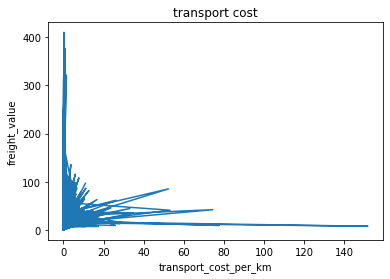

In [154]:
        
# plotting the points  
plt.plot(df["transport_cost_per_km"], df["freight_value"]) 
    
# naming the x axis 
plt.xlabel('transport_cost_per_km') 
# naming the y axis 
plt.ylabel('freight_value') 
    
# giving a title to my graph 
plt.title('transport cost') 
    
# function to show the plot 
plt.show() 